# Project Progress Report
**Date:** April 10th, 2025

**Team Members:**
Alex Cruz,
Miguel Madrigal,
Christian Julias,
Mohsin Patel,
Angel Ramirez


**Link to GitHub Repository:** https://github.com/mmadr5/SteamSalesAndPricingAnalysis

# ===========================================

# 1. Project Introduction
Briefly introduce your project, the dataset, and the problems you aim to investigate:

The goal of our project is to analyze the pricing and discount strategies used on the popular PC gaming platform, Steam. 
As frequent gamers ourselves, we were particularly interested in understanding the patterns behind the widely anticipated Steam sales, 
and how various game attributes influence both regular prices and discount behavior.

To do this, we collected data from several publicly available Steam-related datasets. These datasets include information on game prices, 
genres, user reviews, tags, release dates, and other game-specific metrics.

# ===========================================

# 2. Changes since Proposal
Discuss any changes in the scope or approach since the initial proposal:

Since our initial proposal, the scope and overall approach of our project have remained consistent. 
We haven't added or removed any major components. Our focus continues to be on analyzing Steam game pricing and discount patterns.


# ===========================================

# 3. Data Preparation
Explain the steps taken to prepare your data.


[Describe your data preparation process, including data cleaning, transformations, feature extraction, etc.]
> Our dataset was collected from SteamDB where we first started with the top 100 games in each genre, just   because collecting
data for the entire game catalog on Steam has been time consuming. To clean the data we looked at the price column and removed 
any entry that did not have a price or had a price of 0 which meant it was free, which is not needed for our project. After that we removed 
any duplicates or any rows with missing info like name or genre. 
These steps ensured our dataset was clean, consistent, and ready for analysis related to Steam's pricing patterns and sales strategy.

> For Hypothesis 4, our dataset was collected from SteamDB. We originally curated 100 games across diverse genres and publisher types (AAA vs. Indie). However, due to time constraints and data availability, we focused on a subset of 50 games for collecting detailed price history and review history via downloading through their chart downloads. This is due to SteamDB requiring a valid Steam login with purchase history and frequent downloading causes timeouts and sometimes bans.

In [15]:
# Import necessary libraries
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Dataset Cleaning (Top 100 Sample) ==========
df = pd.read_csv('../Steam_Project/steam_top100_cleaned_data_corrected.csv')

# Clean numeric price
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df[(df['price'] > 0) & (df['price'] <= 210)]
df.drop_duplicates(subset='appid', keep='first', inplace=True)

# Add review stats
df['total_reviews'] = df['positive'] + df['negative']
df['positive_ratio'] = df['positive'] / df['total_reviews'].replace(0, 1)
df['negative_ratio'] = df['negative'] / df['total_reviews'].replace(0, 1)

# Drop rows with critical nulls
df.dropna(subset=['name', 'genre'], inplace=True)
df.reset_index(drop=True, inplace=True)

# ========== Load Historical Data from Review/Price CSVs ==========
review_folder = "ReviewHistory"
price_folder = "PriceHistory"
game_json = "100_Steam_Assortment.json"

with open(game_json, "r", encoding="utf-8") as f:
    games = json.load(f)

appid_type_map = {str(game["appid"]): game["type"] for game in games}
records = []

for appid in appid_type_map:
    review_path = os.path.join(review_folder, f"{appid}.csv")
    price_path = os.path.join(price_folder, f"{appid}.csv")

    if not os.path.exists(review_path) or not os.path.exists(price_path):
        continue

    try:
        review_df = pd.read_csv(review_path)
        price_df = pd.read_csv(price_path)

        review_df.columns = [col.strip().lower() for col in review_df.columns]
        price_df.columns = [col.strip().lower() for col in price_df.columns]

        if "final price" not in price_df.columns or "historical low" not in price_df.columns:
            continue

        review_df["date"] = pd.to_datetime(review_df["datetime"]).dt.date
        price_df["date"] = pd.to_datetime(price_df["datetime"]).dt.date

        review_grouped = review_df.groupby("date").agg({
            "positive reviews": "sum",
            "negative reviews": "sum"
        }).reset_index()

        price_grouped = price_df.groupby("date").agg({
            "final price": "last",
            "historical low": "last"
        }).reset_index()

        merged = pd.merge(review_grouped, price_grouped, on="date", how="inner")
        merged["discount_percent"] = 100 * (merged["final price"] - merged["historical low"]) / merged["final price"]
        merged["discount_percent"] = merged["discount_percent"].clip(lower=0)
        merged["review_volume"] = merged["positive reviews"] + merged["negative reviews"]
        merged = merged.dropna(subset=["discount_percent", "review_volume"])
        merged = merged[merged["review_volume"] > 0]

        for _, row in merged.iterrows():
            records.append({
                "appid": appid,
                "discount_percent": row["discount_percent"],
                "review_volume": row["review_volume"],
                "type": appid_type_map[appid]
            })

    except Exception as e:
        print(f"[{appid}] Error: {e}")
        continue



# ===========================================

# 4. Exploratory Data Analysis (EDA)


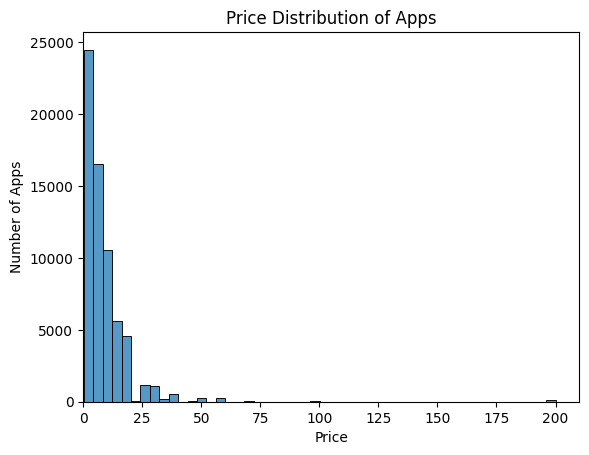

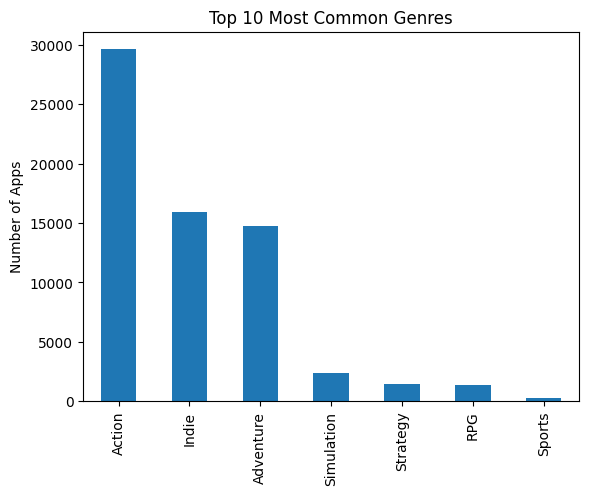

In [22]:
sns.histplot(df['price'], bins=50)

plt.title("Price Distribution of Apps")
plt.xlim(0, 210)
plt.xlabel("Price")
plt.ylabel("Number of Apps")
plt.show()

# Most common genres
from collections import Counter

all_genres = ','.join(df['genre'].dropna()).split(',')
genre_counts = pd.Series(Counter(all_genres)).sort_values(ascending=False)
genre_counts.head(10).plot(kind='bar')
plt.title("Top 10 Most Common Genres")
plt.ylabel("Number of Apps")
plt.show()

# ===========================================

# 5. Hypotheses Visualizations
(At least 5 visualizations with explanations and responsible team members)


### Hypothesis 1:
- Visualization explanation:

    > The distribution of review counts (log-transformed) for only paid Steam apps is displayed in this violin plot.  The x-axis shows if a game's price is zero, although all entries here indicate paid titles (is_free = False), as all free games were filtered out. By lessening the impact of outliers, the log_reviews transformation (log(1 + total_reviews)) helps highlight patterns. With thicker portions showing more games in that category, the graphic displays the density of paid games across different review count ranges. The median and interquartile range are displayed in the box inside the violin, suggesting that the majority of paid games fall within a certain review volume. A long tail at the top indicates that some premium games get a disproportionately large number of reviews. Since free games are not included, we are better able to concentrate on trends in paid games without being swayed by popular free-to-play games. We are more aware of the variation in user engagement (as measured by reviews) in the paid market category thanks to this visualization.

- Why it’s interesting:

    > This visualization is interesting because it highlights the **uneven distribution of user engagement** among paid games on Steam. The quantity of reviews that the games receive varies greatly, despite the fact that they all cost money. A small percentage of paid games receive an excessively large number of reviews, whereas the majority just receive a low amount of attention. According to this long-tailed distribution, a few number of very successful games control user engagement, indicating that **success in the paid gaming market is not fairly shared**. Extreme outliers would otherwise hide these patterns, but the log scale makes them visible. It poses interesting considerations regarding the factors that influence popularity and exposure in the Steam marketplace. Additionally, since being a paid game does not ensure high interaction, it provides information into customer behavior. This plot helps developers and analysts evaluate player interest, spot market saturation, and plan their pricing and marketing strategies. In the end, it demonstrates that popularity among premium games is not merely uncommon, but unexpected.

- Responsible member(s): Angel Ramirez

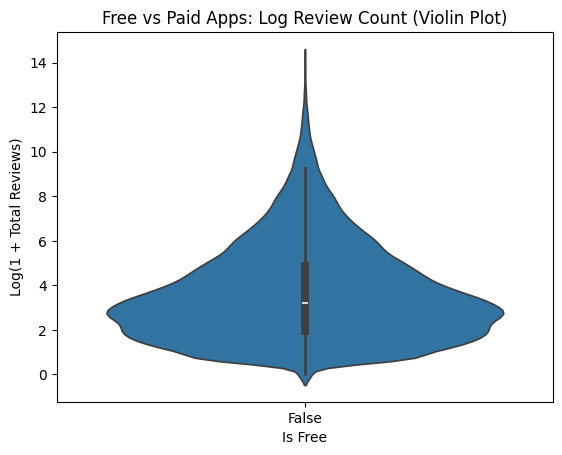

In [21]:
# Add 'is_free' column to indicate whether the app is free
df['is_free'] = df['price'] == 0.00

# Add 'log_reviews' column to calculate log(1 + total_reviews)
import numpy as np
df['log_reviews'] = np.log1p(df['total_reviews'])

# Plot the violin plot
sns.violinplot(x='is_free', y='log_reviews', data=df, inner='box')
plt.title("Free vs Paid Apps: Log Review Count (Violin Plot)")
plt.xlabel("Is Free")
plt.ylabel("Log(1 + Total Reviews)")
plt.show()

### Hypothesis 2:
- Visualization explanation: 

    > The first visualization shows the top 10 game genres with the highest average positive review ratios. Each dot represents a genre, and its size reflects the number of games in that genre. Larger dots mean more games, giving context to how representative the average ratio is. The genres are sorted by positivity, helping us quickly see which genres tend to receive the most favorable feedback from players. For example, if “Indie” appears at the top, it means that on average, players rate Indie games very positively.

    > The second visualization highlights the top 10 genres with the highest average negative review ratios. Like the first chart, dot size indicates how many games are in each genre. A high negative ratio suggests that games in that genre tend to receive more critical or dissatisfied reviews. This helps identify genres that may have issues with gameplay, quality, or audience expectations. Together, both plots give a balanced view of how different genres perform in terms of user sentiment. They can be used to compare genre reputation and player satisfaction patterns in the Steam game ecosystem.

- Why is it intresting? 

    > It reveals which game genres are most loved or criticized by players on average. It helps developers and gamers understand trends in player satisfaction across different genres. By comparing both positive and negative feedback, we can spot genres that may be underrated or overhyped. It also offers insight into how genre popularity relates to review quality, not just quantity.

- Responsible member(s): Alexander Cruz 


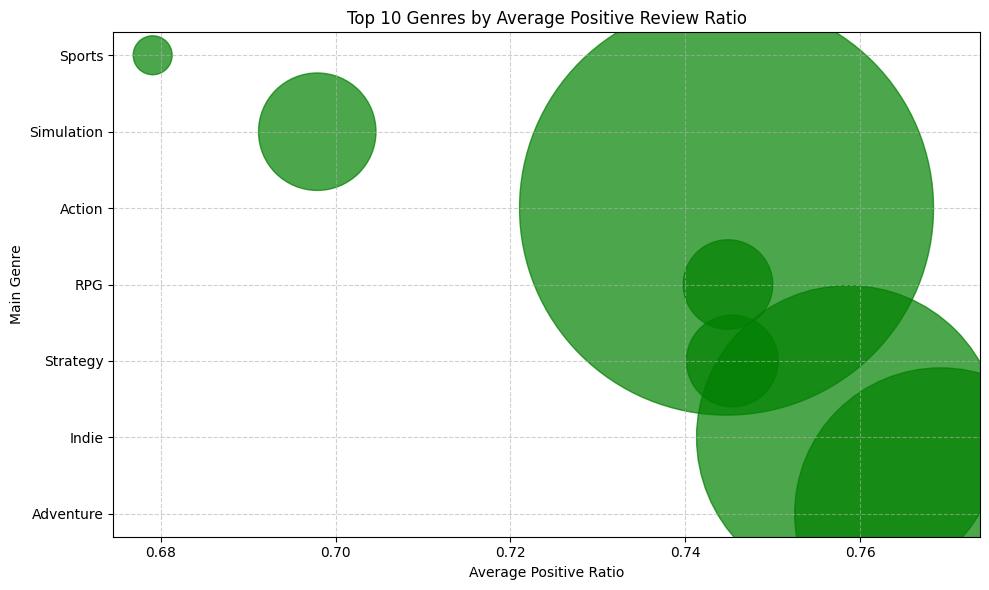

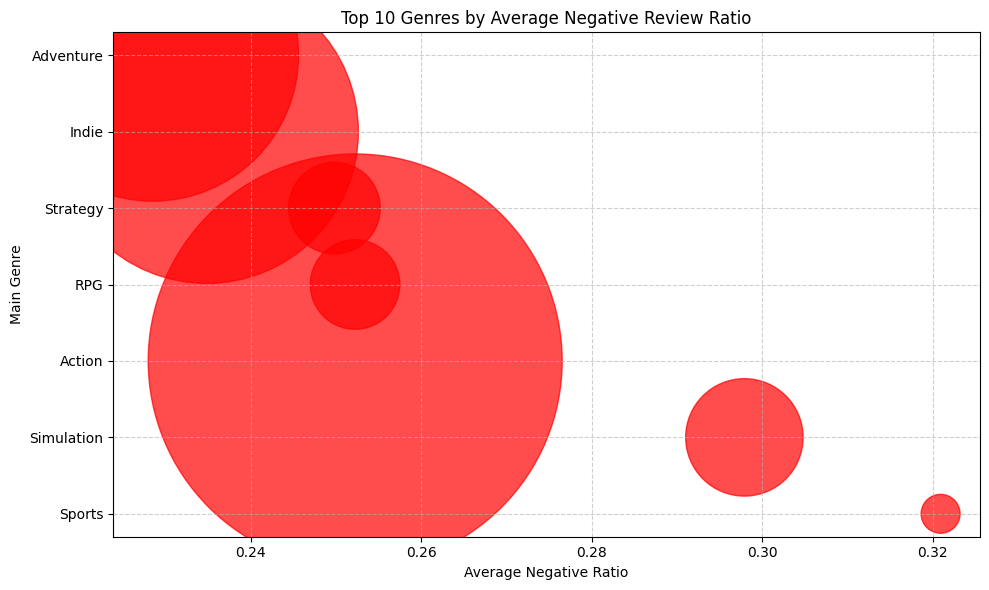

In [20]:
# [Visualization Code]
# Sort and select top 10 by positive ratio

# Extract main genre
df['main_genre'] = df['genre'].str.split(',').str[0]

# Group by main genre and compute averages
genre_summary = df.groupby('main_genre').agg(
    avg_positive_ratio=('positive_ratio', 'mean'),
    avg_negative_ratio=('negative_ratio', 'mean'),
    app_count=('appid', 'count')
).sort_values(by='avg_positive_ratio', ascending=False).head(10)

top_positive = genre_summary.sort_values(by='avg_positive_ratio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.scatter(
    top_positive['avg_positive_ratio'],
    top_positive.index,
    s=top_positive['app_count'] * 3,
    alpha=0.7,
    color='green'
)
plt.title("Top 10 Genres by Average Positive Review Ratio")
plt.xlabel("Average Positive Ratio")
plt.ylabel("Main Genre")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Sort and select top 10 by negative ratio
top_negative = genre_summary.sort_values(by='avg_negative_ratio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.scatter(
    top_negative['avg_negative_ratio'],
    top_negative.index,
    s=top_negative['app_count'] * 3,
    alpha=0.7,
    color='red'
)
plt.title("Top 10 Genres by Average Negative Review Ratio")
plt.xlabel("Average Negative Ratio")
plt.ylabel("Main Genre")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Hypothesis 3:
- Visualization explanation: 

    > This visualization shows us the box plots of the positive review ratio of 7 different price ranges of games. The price ranges are $0.25-$1, $1-$5, 5$-10$, 10$-20$, 20$-50$, 50$-100$, and $100+.
    > From the price range of 0.25-1 we find that the spread of positive reviews ranges from 0 to 1.0. The median is around 0.75. The interquartile range is from about 0.5 to 0.9. The spread is already wide so we dont see many outliers.
    > From the price range of 1-5 we find that the spread of positive reviews ranges from 0.1 to 1.0. The median is around 0.80. The interquartile range is from about 0.6 to 0.95. We are now seeing more outliers start to show at the 0.0 - 0.1 positive review ratio.
    > From the price ranges of 5-10, 10-20, and 20-50 we see a similar spread of data from about 0.35 to 1.0. The median is consistent around 0.80. The interquartile range is also consistent around 0.70 to 0.90. We also see lots of outliers on the lower end of the ratings ranging from 0.0 - 0.4.
    > From the ranges of 50-100 we see the same outcome as the 5-50 price range except this time there are far less outliers especially at the really low end.
    > The 100+ price range is where the data really differs. The spread of data is spread wide from 0.0 to 1.0. The median rating is the lowest at just 0.4. The interquartile range is from 0.3 - 0.7. The spread is already wide so we dont see many outliers.

- Why is it interesting? 

    > This is interesting because it shows us how much cost really impacts the positive reviews that people leave on games. For the 0.25-1 price range there is a wide spread of reviews because there really isn't consistent quality in cheaper games. Since people aren't spending that much money ratings for these games are still quite high. When games cost more money (around the 1-50 price range) we start to see more outliers meaning that users are likely to leave lower reviews if they spend more money on the game they bought. The median still remains quite high for these games however. The 50-100 price range is typically where AAA games are priced and the median positive review ratio still remained high but we actually see less outliers compared to the games priced in the 5-50 range which is surprising. At the 100+ price range we see the lowest positive reviews with a median at 0.4 and a really wide spread of data. This is a considerable amount of money to spend on a game and users are less likely to leave a positive review as a result.

- Responsible member(s): Mohsin Patel

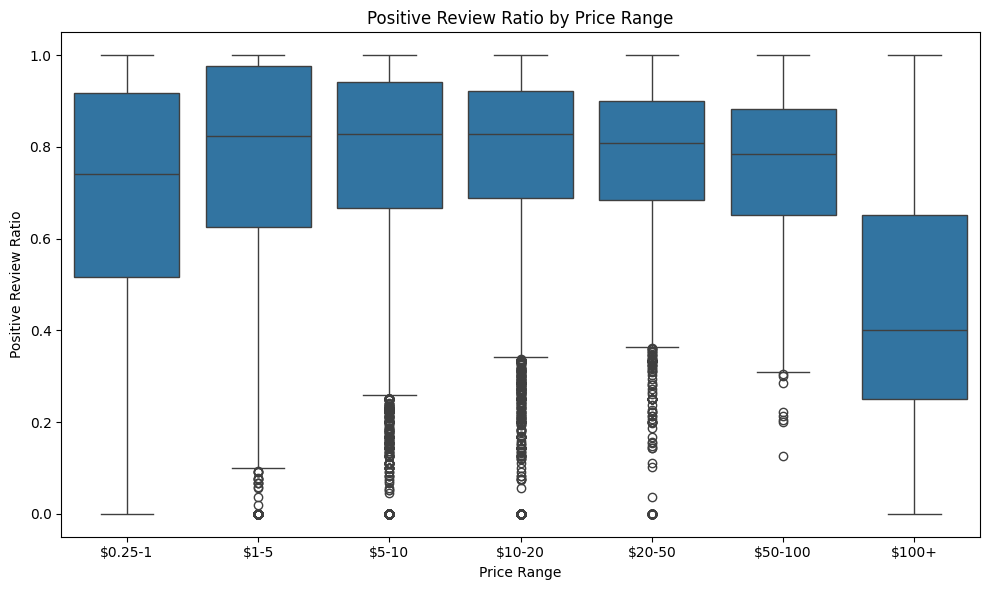

In [19]:
# [Visualization Code]
# Create price bins
df['price_bin'] = pd.cut(df['price'], bins=[0, 1, 5, 10, 20, 50, 100, 200], labels=['$0.25-1', '$1-5', '$5-10', '$10-20', '$20-50', '$50-100', "$100+"], include_lowest=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='price_bin', y='positive_ratio', data=df)
plt.title("Positive Review Ratio by Price Range")
plt.xlabel("Price Range")
plt.ylabel("Positive Review Ratio")
plt.tight_layout()
plt.show()

### Hypothesis 4:
- Visualization explanation: 

    > The scatter plot visualizes the relationship between discount percentage and daily review volume for 50 selected games. Points are color-coded by game type (AAA vs Indie). The x-axis represents the discount percentage applied on a given day, while the y-axis shows the number of user reviews (positive + negative) submitted that same day. A regression line is plotted to estimate overall correlation.

    > The chart suggests that heavier discounts (e.g., 40–80%) are often correlated with higher spikes in review volume, particularly for AAA games. Indie games show review spikes more uniformly across all discount levels, including moderate discounts (10–30%). Some games like PUBG became free so reviews were accounted on the 100% discount.

- Why is it intresting? 

    > This visualization is crucial for understanding how player engagement, reflected by review frequency, responds to price changes. It provides evidence that sales events can drive more player feedback, especially for major titles. Moreover, the difference in trend between AAA and indie games suggests that consumer sensitivity to discounts varies by market segment.

    > The plot helps support the idea that sales periods represent key touchpoints for community interaction, and that publishers can potentially use discounting strategies to prompt player attention and word-of-mouth via Steam reviews. Think of your favorite YouTubers and Twitch Streamers talking about that new game or exciting game that is now on sale. 

    > This finding lays the groundwork for more granular analysis, such as whether the sentiment of those reviews changes significantly during sales. However, we need more games to improve this analysis

- Responsible member(s): Miguel Madrigal

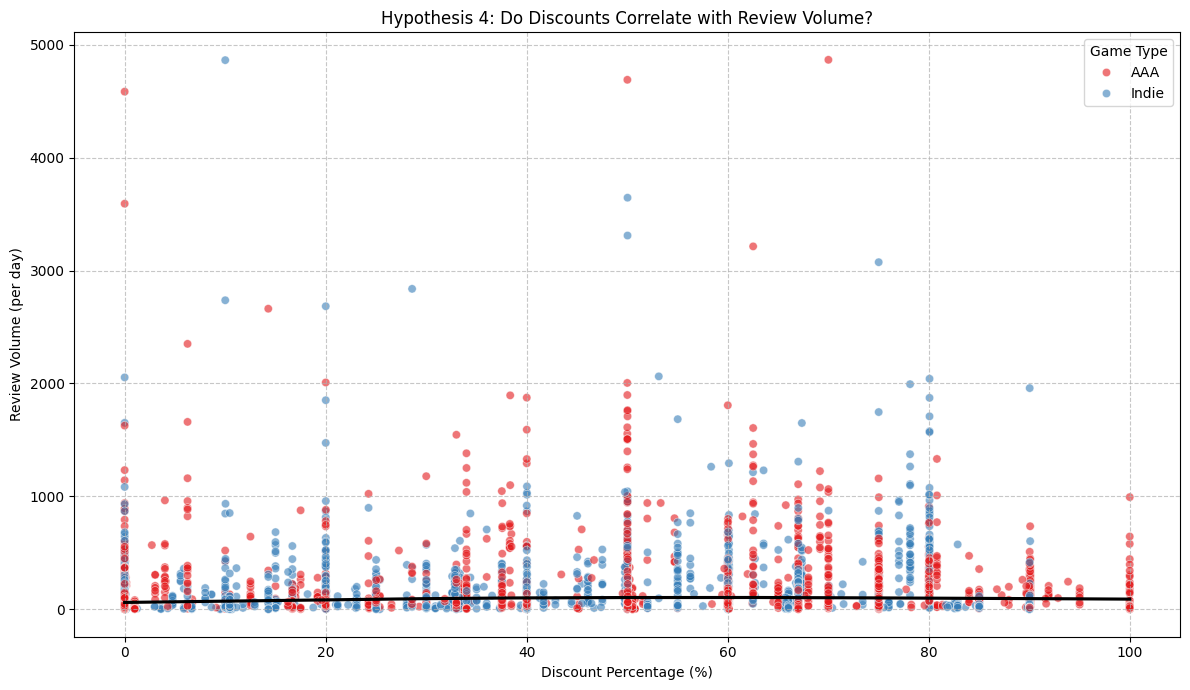

In [18]:
# [Visualization Code]
if df_discount_reviews.empty:
    print("No data to visualize.")
else:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=df_discount_reviews,
        x="discount_percent",
        y="review_volume",
        hue="type",
        alpha=0.6,
        palette="Set1"
    )
    sns.regplot(
        data=df_discount_reviews,
        x="discount_percent",
        y="review_volume",
        scatter=False,
        lowess=True,
        color="black"
    )

    plt.title("Hypothesis 4: Do Discounts Correlate with Review Volume?")
    plt.xlabel("Discount Percentage (%)")
    plt.ylabel("Review Volume (per day)")
    plt.legend(title="Game Type")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### Hypothesis 5:
- Visualization explanation:
- Responsible member(s):

# 6. Machine Learning Analyses
(At least 2 analyses with baselines and explanations)

**Analysis 1:**
- ML technique explanation:
  > We used logistic regression to model the probability of a binary outcome happening. We want to predict when a game is highly rated or not. The inputs we use are the price of the game and the total reviews the game has received.
- Baseline used:
  > The baseline used would be predicting that all games are highly rated since most ratings are skewed to being positive.
- Results interpretation:
  > Our model is biased to predicting games are highly rated because the majority class is true. It struggles to predict when the result is false. This tells us that we may need a bigger dataset with different features so that we have different features to help predict whether a game is highly rated or not since price and total reviews alone does not do a great job at helping the model predict correctly.
- Responsible member(s): Mohsin Patel

In [6]:
# [ML Analysis Code]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df['is_highly_rated'] = df['positive_ratio'] >= 0.8

X = df[['price', 'total_reviews']]
y = df['is_highly_rated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.71      0.01      0.02      6135
        True       0.54      1.00      0.70      7010

    accuracy                           0.54     13145
   macro avg       0.62      0.50      0.36     13145
weighted avg       0.62      0.54      0.38     13145



**Analysis 2:**
- ML technique explanation:
> We used simple linear regression to examine whether a game’s daily discount percentage can predict its daily review volume. This involved merging Steam price history and review history across 50 games, calculating per-day discount percentages, and summing positive and negative reviews to get total review volume.
- Baseline used:
> Our baseline is the assumption that review volume stays constant regardless of discounts. We compare our regression model’s performance to this by using R²
- Results interpretation:
> The model produced an R² score of 0.0145 and a mean absolute error of 162.07.
This means discount percentage alone explains less than 2% of the variation in review volume, and the model's predictions are off by about 162 reviews per day on average.
These results indicate that discounts may influence review activity but are not a strong standalone predictor. Other variables like game popularity, update cycles, and Steam events likely play a larger role.
- Responsible member(s): Miguel Madrigal

In [33]:

# [ML Analysis Code]

X = df[["discount_percent"]]
y = df["review_volume"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print model performance
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")



R² Score: 0.0145
Mean Absolute Error: 162.07


# ===========================================

# 7. Reflection
*Address the reflection points:*

- **Most challenging part so far:** Gathering data or finding useful consistent data has been a nightmare

- **Initial insights:**

- **Concrete results available:**

- **Current biggest problems:**

- *Are you on track?*

- *Worth proceeding with the current approach?*

# ===========================================

# 8. Next Steps
Outline concrete plans and goals for the next month.

- In the last week we found a dataset table that lists the games currently on steam. We hope to use this table to retrieve current price and review data.
- We recently retrieved a table that has listed publisher data classed by AAA, AA, Indie, and Hobbyist. As well other relevant data per publisher that we can leverage in our study.
- [Goal 3]